<a href="/assets/lecture08_code.ipynb" class="link-button">Download</a>
<a href="https://colab.research.google.com/github/technion046195/technion046195/blob/master/content/lecture08/code.ipynb" target="_blank">
<img src="../assets/colab-badge.svg" style="display:inline"/>
</a>

<center><h1>
הרצאה 8 - שיערוך פילוג בשיטות פרמטריות וסיווג גנרטיבי
</h1></center>

## Setup

In [ ]:
## Importing packages
import os # A build in package for interacting with the OS. For example to create a folder.
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package
import imageio  # A package to read and write image (is used here to save gif images)
import tabulate  # A package from pretty printing tables
from graphviz import Digraph  # A package for plothing graphs (of nodes and edges)

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (4.5, 4.5)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations, pandas tables and images in cells output
from IPython.core.display import display, HTML, Latex, Markdown

## Create output folder
if not os.path.isdir('./output'):
    os.mkdir('./output')

## Drive time distribution

In [ ]:
x = np.array([55,68,75,50,72,84,65,58,74,66])
x_grid = np.arange(30, 120, 0.01)

In [ ]:
k_thumb = 1.06 * np.std(x) / 10 ** (1 / 5)
print(k_thumb)

6.5054057094585716


In [ ]:
kernel = lambda x: 1 / (2 * np.pi) ** 0.5 * np.exp(-(x ** 2) / 2)
def kde(x_grid, x, kernel, h):
    pdf = np.zeros(x_grid.shape[0])
    for x0 in x:
        pdf += 1 / h * kernel((x_grid - x0) / h) / x.shape[0]
    return pdf

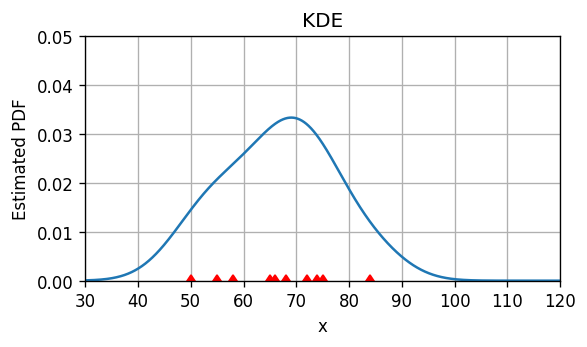

In [ ]:
h = k_thumb

pdf = kde(x_grid, x, kernel, h)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x_grid, pdf)
ax.plot(x, np.zeros_like(x), 'dr', ms=5, label='dataset')
ax.set_title('KDE')
ax.set_xlabel('x')
ax.set_ylabel('Estimated PDF')
ax.set_xlim(30, 120)
ax.set_ylim(0, 0.05)
plt.tight_layout()
fig.savefig('./output/drive_time_kde.png', dpi=240)

66.7
9.726767191621274


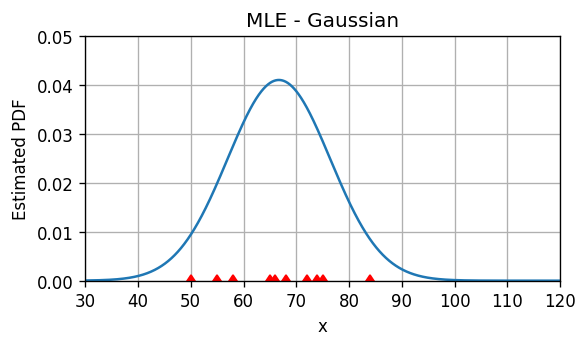

In [ ]:
std = np.std(x)
mean = np.mean(x)

print(mean)
print(std)


pdf = 1 / ((2 * np.pi) ** 0.5 * std) * np.exp(-(x_grid - mean) ** 2 / 2 / std ** 2)
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(x_grid, pdf)
ax.plot(x, np.zeros_like(x), 'dr', ms=5, label='dataset')
ax.set_title('MLE - Gaussian')
ax.set_xlabel('x')
ax.set_ylabel('Estimated PDF')
ax.set_xlim(30, 120)
ax.set_ylim(0, 0.05)
plt.tight_layout()
fig.savefig('./output/drive_time_mle.png', dpi=240)


In [ ]:
sigma_mu = 5
mu_mu = 60
sigma = 10

mu_map = (sigma ** 2 / sigma_mu ** 2 / x.shape[0] * mu_mu + np.mean(x)) / (sigma ** 2 / sigma_mu ** 2 / x.shape[0] + 1)
print(mu_map)

64.78571428571429


## Credit Card Fraud Detection

In [ ]:
mean_legit = np.array([54, 54])
std_legit = 18
mean_fraud1 = np.array([27, 27])
std_fraud1 = 7.2
mean_fraud2 = np.array([81, 81])
std_fraud2 = 7.2

n_legit = 200
n_fraud1 = 25
n_fraud2 = 25

rand_gen = np.random.RandomState(1)

x = np.concatenate((
        rand_gen.randn(n_legit, 2) * std_legit + mean_legit,
        rand_gen.randn(n_fraud1, 2) * std_fraud1 + mean_fraud1,
        rand_gen.randn(n_fraud2, 2) * std_fraud2 + mean_fraud2,
    ), axis=0)

y = np.concatenate((np.zeros(n_legit, dtype=bool), np.ones(n_fraud1 + n_fraud2, dtype=bool)))

x_grid = np.stack(np.meshgrid(np.linspace(0, 100, 300), np.linspace(0, 100, 300)), axis=2)

In [ ]:
from matplotlib.colors import ListedColormap
def plot_grid_predict(ax, h, x_grid):
    cmap = ListedColormap(plt.cm.tab10([0, 1]))
    grid_predict = h(x_grid.reshape(-1, 2)).reshape(x_grid.shape[:2])
    img_obj = ax.imshow(grid_predict, extent=[0, 100, 0, 100],
              origin='lower',
              cmap=cmap,
              alpha=0.2,
              interpolation='nearest',
              zorder=-1,
              )
    return img_obj

### Train-Test Split

In [ ]:
n_samples = x.shape[0]

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(1)

## Generating a vector of indices
indices = np.arange(n_samples)

## Shuffle the indices
rand_gen.shuffle(indices)

## Split the indices into 80% train / 20% test
n_samples_train = int(n_samples * 0.8)
train_indices = indices[:n_samples_train]
test_indices = indices[n_samples_train:]

x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

### The dataset

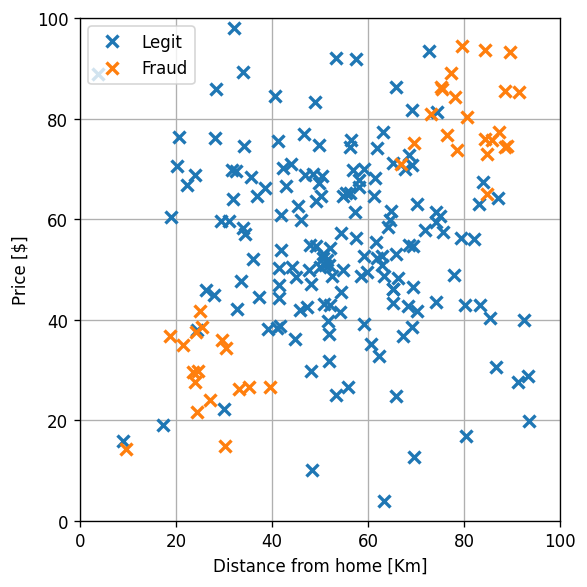

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x_train[~y_train, 0], x_train[~y_train, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x_train[y_train, 0], x_train[y_train, 1], 'x', label='Fraud', ms=7, mew=2)
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.tight_layout()
ax.legend(loc='upper left')
fig.savefig('./output/transactions_dataset.png', dpi=240)

## Naive Bayes + KDE

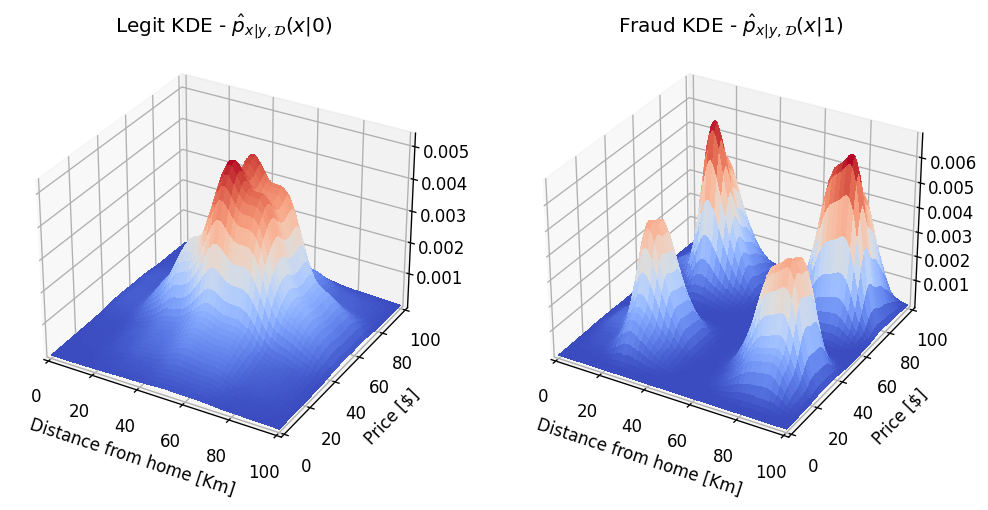

In [ ]:
kernel = lambda x: 1 / (2 / np.pi) ** 0.5 * np.exp(-(x ** 2) / 2)
def kde(x_grid, x, kernel, h):
    pdf = np.zeros(x_grid.shape[0])
    for x0 in x:
        pdf += 1 / h * kernel((x_grid - x0) / h) / x.shape[0]
    return pdf

def calc_cond_pdf(x_grid, x, kernel, h):
    pdf = np.ones(x_grid.shape[0])
    for i_col in range(x.shape[1]):
        pdf *= kde(x_grid[:, i_col], x[:, i_col], kernel, h)
    return pdf

h = 4

fig = plt.figure(figsize=(10, 5))

pdf_legit = calc_cond_pdf(x_grid.reshape(-1, 2), x_train[~y_train], kernel, h).reshape(x_grid.shape[0], x_grid.shape[1])
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(x_grid[:, :, 0], x_grid[:, :, 1], pdf_legit, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_title('Legit KDE - $\hat{p}_{x|y,\mathcal{D}}(x|0)$')
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')

pdf_fraud = calc_cond_pdf(x_grid.reshape(-1, 2), x_train[y_train], kernel, h).reshape(x_grid.shape[0], x_grid.shape[1])
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(x_grid[:, :, 0], x_grid[:, :, 1], pdf_fraud, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_title('Fraud KDE - $\hat{p}_{x|y,\mathcal{D}}(x|1)$')
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
fig.savefig('./output/transactions_naive_pdf.png', dpi=240)

### Predictions

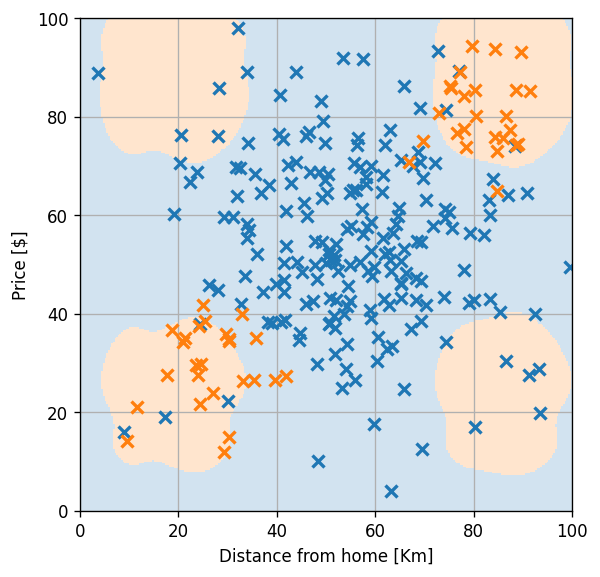

In [ ]:
h_func = lambda x_in: calc_cond_pdf(x_in, x_train[y_train], kernel, h) * 0.2 > calc_cond_pdf(x_in, x_train[~y_train], kernel, h) * 0.8

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(x[~y, 0], x[~y, 1], 'x', label='Legit', ms=7, mew=2)
ax.plot(x[y, 0], x[y, 1], 'x', label='Fraud', ms=7, mew=2)
plot_grid_predict(ax, h_func, x_grid)
ax.set_xlabel('Distance from home [Km]')
ax.set_ylabel('Price [$]')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.tight_layout()
fig.savefig('./output/transactions_naive_predictions.png', dpi=240)

In [ ]:
y_hat = h_func(x_test)
test_score = (y_hat != y_test).mean()

display(Markdown(f'The test score is {test_score:.3f}'))

The test score is 0.140